# AOS_update_segmentation gain/readNoise DM-...

Need to update https://github.com/lsst-ts/phosim_syseng4/blob/aos/data/lsst/segmentation.txt  gain and read noise values to make them consistent with those in lsstCamMapper ( eg. https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R00.yaml ). 

Currently, the values in `segmentation.txt` are consistent with PhosimMapper, but DM-26836 creates a need to move to LsstCamMapper. Thus the calibration files (made with `makeGainImages.py` https://github.com/lsst-dm/phosim_utils/blob/master/bin.src/makeGainImages.py need to use geometry and gain values consistent with LsstCam. 



## Development of code to update segmentation.txt :

In [1]:
from lsst.obs.lsst import LsstComCam
LsstComCam?

Init signature: LsstComCam()
Docstring:     
Gen3 Butler specialization for ComCam data.
    
File:           /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/python/lsst/obs/lsst/_instrument.py
Type:           ABCMeta
Subclasses:     


Init signature: LsstComCam()
Docstring:     
Gen3 Butler specialization for ComCam data.
    
File:           /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/python/lsst/obs/lsst/_instrument.py
Type:           ABCMeta
Subclasses:     


Take the current values encoded in segmentation.txt

In [1]:
pathToFile = '/project/scichris/aos/phosim_syseng4/data/lsst/segmentation_old.txt'

Lines longer than 4 have the following content: 

        # (1): amplifier name
        # (2-5): x low, x high, y low, y high
        # (6): serialread
        # (7): parallelread
        # (8-9): gain, % variation
        # (10-11): bias level, % variation
        # (12-13): readnoise , % variation
        # (14-15): dark current, % variation
        # (16-19): parallel prescan, serial overscan, serial prescan, parallel overscan (pixel)
        # (20): hot pixel rate
        # (21): hot column rate
        # (22-35): crosstalk
        
Eg. 

    (1)  'R44_S10_C17',amplifier name
    (2-5) '2000', '3999 ', '3563', '4071':  x low, x high, y low, y high 
    (6) '1':  serialread 
    (7) '1' :  parallelread
    (8-9) '1.732','0' :   gain, % variation 
    (10-11) '1000.0', '2.0'  : bias level, % variation 
    (12-13) '4.02', '0': readnoise , % variation 
    (14-15) '0.02', '0.0': dark current, % variation
    (16-19) '3','0', '10',  '10': parallel prescan, serial overscan, serial prescan, parallel overscan
    (20) '0.00000012': hot pixel rate
    (21) '0.00000012': hot column rate
    (22-35) '18', '-1.791e-05', '-2.663e-05', '-2.884e-05', '-4.986e-05',
     '-2.880e-05', '-4.244e-05', '+0.000e+00', '+0.000e+00', '+0.000e+00', '-1.158e-05', '-2.943e-05', '-4.526e-05', '-1.788e-05', '-1.953e-05', '+4.797e-04', '+1.000e+00\n' :crosstalk 

In [6]:
# read all the lines to a list : 
with open(pathToFile) as f:
    allLines = f.readlines()
    
headerLines=[]
contentLines=[]
# store the header part and content separately 
for line in allLines:
    if line.startswith('#'):
        headerLines.append(line)
    else:
        contentLines.append(line)

In [10]:
# show that I can write that back to a file 
f = open("segmentation_test.txt", "w")
f.writelines(allLines)
f.close()

In [52]:
#contentLines

In [46]:
testLines = contentLines[:100]

In [47]:
#testLines

In [66]:
# store the segmentation.txt data into a dictionary...
# it makes it easier to access the data for 
# each element and compare to the old one ... 

sensorData = {}
# gather data from all sensors  into a dictionary  
for i in range(len(contentLines)):
    # iterate over lines
    line = contentLines[i]
    
    # the beginning of the short line is a sensor name.
    # store the name 
    # if the line is longer, it continues using that name
    # until the next short line 
    if len(line)<50:
        
        sensorName = line.split(' ')[0]
        #print('Short line! Updating name to %s'%sensorName)
        # initialize the dict for that sensor...
        sensorData[sensorName] = []
        
    # this continues with each line that starts with that
    # sensor name ... 
    # it also works for corner sensors, because 
    # _C0  contain C0x amps,
    # _C1 contain C1x amps... 
    if line.split(' ')[0].startswith(sensorName):
        #print(line)
        sensorData[sensorName].append(line)
        


In [192]:
guideSensorMapping = {'R04_S10':'R04_SG0', 
                      'R04_S21':'R04_SG1', 
                      'R44_S01':'R44_SG0', 
                      'R44_S10':'R44_SG1', 
                      'R00_S12':'R00_SG0', 
                      'R00_S21':'R00_SG1', 
                      'R40_S01':'R40_SG0', 
                      'R40_S12':'R40_SG1'
                     }

# C0 : intra-focal  - SW1 
# C1 : extra-focal  - SW0 
cornerSensorMapping = {'R04_S20_C0':'R04_SW1',
                       'R04_S20_C1':'R04_SW0',
                       'R44_S00_C0':'R44_SW1',
                       'R44_S00_C1':'R44_SW0',
                       'R00_S22_C0':'R00_SW1',
                       'R00_S22_C1':'R00_SW0',
                       'R40_S02_C0':'R40_SW1',
                       'R40_S02_C1':'R40_SW0'
                      }
# phosim corner wavefront
# amplifier names to lsst cam
ch_map = {'00': '17',
                '01': '16',
                '02': '15',
                '03': '14',
                '04': '13',
                '05': '12',
                '06': '11',
                '07': '10',
                '10': '17',
                '11': '16',
                '12': '15',
                '13': '14',
                '14': '13',
                '15': '12',
                '16': '11',
                '17': '10'}
    
    

All-in-one, later to split into functions: 

In [179]:
newSensorData  = {}
  
for sensorName in list(sensorData.keys())[:4]:
    print('Running %s'%sensorName)
    # alter the name of the corner sensors to be able to
    # access lsstCam data 
    if sensorName in cornerSensorMapping.keys():
        newName = cornerSensorMapping[sensorName]
        #print('corner: %s --> %s'%(sensorName, newName))
        
    elif sensorName in guideSensorMapping.keys():
        newName = guideSensorMapping[sensorName]
        #print('guide: %s --> %s ' %(sensorName, newName))
        
    # otherwise, name remains unchanged 
    else: 
        newName = sensorName
    
    # get the lsstCam data for that sensor 
    #print(newName)
    lsstCamDetectors = camera.get(newName)
    
    # initialize a list for the new data 
    newSensorData[newName] = []
    
    for content in sensorData[sensorName]:
        splitContent = content.split(' ')
        newSplitContent = splitContent.copy()
        
        # first line contains sensor name, number of amps, and ccd dimensions, eg.
        
        if len(content)<40:
            #sensorName = splitContent[0]
            newSplitContent[0] = newName
            
            
        if len(content)>40:
            #continue
            #print(len(content), content)
            
            sensorAmpName = splitContent[0]
            ampName = sensorAmpName.split('_')[2]
            ampGain = splitContent[7]
            ampBias  = splitContent[9]
            ampReadNoise = splitContent[11]
            ampDarkCurrent = splitContent[13]

            #print('%s: gain %s, bias %s, noise %s, dc %s'% (sensorAmpName, ampGain, ampBias, ampReadNoise, ampDarkCurrent ))
            #print(content)
            #newContent = splitContent.copy()
            
            # change the name of corner sensor amplifiers 
            if sensorName in cornerSensorMapping.keys():
                ampName = 'C%s'%ch_map[ampName[1:]]
            
            newSensorAmpName = '%s_%s'%(newName, ampName)
            newSplitContent[0] = newSensorAmpName
            # read the lsstCam information for that sensor / amp ... 
            for amp in lsstCamDetectors:
                if amp.getName() == ampName:
                    newAmpGain = str(amp.getGain())
                    newAmpReadNoise = str(amp.getReadNoise()) 
                    #print('%s: gain %s --> %s, noise %s --> %s'%(ampName, ampGain, newAmpGain, 
                    #                                             ampReadNoise, newAmpReadNoise))
                    if float(newAmpGain) > 2 :
                        print('   %s: gain %s --> %s, suspicious value '%(ampName, ampGain, newAmpGain))
                    # replace the content values ... 
                    newSplitContent[7] = newAmpGain
                    newSplitContent[11] = newAmpReadNoise
                    #print(newContent)
                    
        # either way, make new content by joining the elements of 
        # the updated split content: 
        newContent = ' '.join(newSplitContent)
        #print(newContent)
        
        
        # add the new content line to the new dictionary 
        newSensorData[newName].append(newContent)

Running R00_S12
Running R00_S21
Running R00_S22_C0
Running R00_S22_C1


In [187]:
# combine the new content as a long list of lines 
newContentLines = []
for sensorName in newSensorData.keys():
    for line in newSensorData[sensorName]:
        newContentLines.append(line)
        
# write the unchanged header, and the new content,
# into a new segmentation.txt file 
f = open("segmentation_test.txt", "w")
f.writelines(headerLines)
f.writelines(newContentLines)
f.close()

In [168]:
a.join?

Signature: a.join(iterable, /)
Docstring:
Concatenate any number of strings.

The string whose method is called is inserted in between each given string.
The result is returned as a new string.

Example: '.'.join(['ab', 'pq', 'rs']) -> 'ab.pq.rs'
Type:      builtin_function_or_method


In [169]:

' '.join(newContent)

'R00_SG1_C17 2000 3999 3563 4071 1 1 1.7 0 1000.0 2.0 4.12 0 0.02 0.0 3 0 10 10 0.00000012 0.00000012 18 -1.791e-05 -2.663e-05 -2.884e-05 -4.986e-05 -2.880e-05 -4.244e-05 +0.000e+00 +0.000e+00 +0.000e+00 -1.158e-05 -2.943e-05 -4.526e-05 -1.788e-05 -1.953e-05 +4.797e-04 +1.000e+00\n'

Test reading the content of one line, the order is key here ... 

In [39]:
# eg. print line 24
for line in allLines:
    if line.startswith('R44_S10_C17'):
        print(line)
        
# eg. split that line by empty space, and thus print sensorName, gain, readNoise...
splitContent = line.split(' ')
sensorAmpName = splitContent[0]
ampGain = splitContent[7]
ampBias  = splitContent[9]
ampReadNoise = splitContent[11]
ampDarkCurrent = splitContent[13]

print('%s: gain %s, bias %s, noise %s, dc %s'%
      (sensorAmpName, ampGain, ampBias, ampReadNoise, ampDarkCurrent )
     )

R44_S10_C17 2000 3999 3563 4071 1 1 1.732 0 1000.0 2.0 4.02 0 0.02 0.0 3 0 10 10 0.00000012 0.00000012 18 -1.791e-05 -2.663e-05 -2.884e-05 -4.986e-05 -2.880e-05 -4.244e-05 +0.000e+00 +0.000e+00 +0.000e+00 -1.158e-05 -2.943e-05 -4.526e-05 -1.788e-05 -1.953e-05 +4.797e-04 +1.000e+00

R44_S10_C17: gain 1.732, bias 1000.0, noise 4.02, dc 0.02


In [13]:
sensor  = 'R32_S11'
for line in open(pathToFile):
    content = line.split(' ')
    #if content[0] != '#':
    if content[0].startswith(sensor):
        #print(content[0], len(content))
        if len(content) > 7:
            #print(content)
            amp_name = content[0].split('_')[2]
            #print(amp_name)
            gain = float(content[7])
            print(sensor,amp_name, gain)
           
           

R32_S11 C00 1.695
R32_S11 C01 1.734
R32_S11 C02 1.657
R32_S11 C03 1.731
R32_S11 C04 1.638
R32_S11 C05 1.701
R32_S11 C06 1.772
R32_S11 C07 1.696
R32_S11 C10 1.742
R32_S11 C11 1.774
R32_S11 C12 1.75
R32_S11 C13 1.663
R32_S11 C14 1.662
R32_S11 C15 1.67
R32_S11 C16 1.783
R32_S11 C17 1.657


Check out the values for readNoise / gain in the lsstCamMapper... 

In [9]:
from lsst.obs.lsst import LsstCam
sensor = 'R32_S11'
camera = LsstCam().getCamera()

# get just one detector... names in segmentation.txt are the same 
# as in LsstCam, apart from 
# 1) corner sensors 
#  so need to iterate over 
detectors = camera.get(sensor)


In [6]:
mapperNames = []
for name in camera.getNameIter():
    mapperNames.append(name)#print(name)

In [193]:
import numpy as np
#np.ravel(mapperNames)

Use this occasion to update the amplifier names (?) - that way the names (prior to geometry) would be  consistent with LsstCam.

The main raft is ok - same sensor and amplifier names . 

The corner rafts would need an update: 


segmentation.txt     ---> lsstCam  :  

R00_S22_C0 ( intra),  with C00, C01, C02 ...  ----> R00_SW1 , with C17, C16, C15 ...
R00_S22_C1 (extra ), with C10, C11, C12 ...  --> R00_SW0 , with C17, C16, C15 ... 

thus a mapping : 


if sensorName ends with C0 (intra) , then 

       * amp mapping is 


            # SW1, intra-focal:
            # phosim into lsstCam 
            ch_map_intra = {'00': '17',
                            '01': '16',
                            '02': '15',
                            '03': '14',
                            '04': '13',
                            '05': '12',
                            '06': '11',
                            '07': '10'}
      * sensorName becomes   Rxx_SW1

if sensorName ends with C1 (extra), then 

       * amp mapping is 

            # SW0, extra-focal
            # phosim into lsstCam 
            ch_map_extra = {'10': '17',
                            '11': '16',
                            '12': '15',
                            '13': '14',
                            '14': '13',
                            '15': '12',
                            '16': '11',
                            '17': '10'}

       * sensorName becomes Rxx_SW0 

   
   

But then would need to update the focalplanelayout.txt  as well... And I don't understand how does phoSim decide what is a standalone ccd and what is part of a larger ccd  ? The corner sensors  in lsstCam are treated as separate sensors, yet phoSim makes  

Go over each line in segmentation.txt  - if the sensor name is in the list of lsstCamSensors, then for each amp in the mapper,  read the amp gain and read noise from the mapper. 
Split the line, and make reassemble by using the new values . 

If the name is not in lsstCamSensors, use the dictionary, translating 

R00_S22_C0 --> R00_SW1 ,  R00_S22_C1 --> R00_SW0 , etc., and amp

# Production: all code needed to update segmentation.txt

In [12]:
from lsst.obs.lsst import LsstCam
import numpy as np 

def readFile(pathToFile, headerString = '#'):
    ''' Read file line-by-line  as two lists,
    one containing the header lines, 
    the other the content lines 
    
    Parameters:
    -----------
    pathToFile: `str`
        absolute path to file 
        
    Returns:
    ----------
    `list`, `list` 
        lists containing the header lines 
        and the content lines 
    '''
    with open(pathToFile) as f:
        allLines = f.readlines()

    headerLines=[]
    contentLines=[]

    # store the header part and content separately 
    for line in allLines:
        if line.startswith('#'):
            headerLines.append(line)
        else:
            contentLines.append(line)

    return headerLines, contentLines 

def storeSensorDataAsDictionary(contentLines):
    '''Store the content of phoSim segmentation
    file as dictionary, with sensor names as keys
    
    Parameters:
    ----------
    contentLines: `list` 
        list of content lines (not starting with #)
        
    Returns:
    ----------
    sensorData: `dict` '''
    
    # store the segmentation.txt data into a dictionary...
    # it makes it easier to access the data for 
    # each element and compare to the old one ... 

    sensorData = {}
    # gather data from all sensors  into a dictionary  
    for i in range(len(contentLines)):
        # iterate over lines
        line = contentLines[i]

        # the beginning of the short line is a sensor name.
        # store the name 
        # if the line is longer, it continues using that name
        # until the next short line 
        if len(line)<50:

            sensorName = line.split(' ')[0]
            #print('Short line! Updating name to %s'%sensorName)
            # initialize the dict for that sensor...
            sensorData[sensorName] = []

        # this continues with each line that starts with that
        # sensor name ... 
        # it also works for corner sensors, because 
        # _C0  contain C0x amps,
        # _C1 contain C1x amps... 
        if line.split(' ')[0].startswith(sensorName):
            #print(line)
            sensorData[sensorName].append(line)
            
    return sensorData 

    
def getNewSensorName(sensorName):
    '''Get updated sensor names
    
    Parameters:
    -----------
    sensorName: `str` 
        input sensor name to translate 
    
    
    Returns:
    --------
    `str` 
        translated sensor name 
    '''
    # mapping 
    guideSensorMapping = {'R04_S10':'R04_SG0', 
                          'R04_S21':'R04_SG1', 
                          'R44_S01':'R44_SG0', 
                          'R44_S10':'R44_SG1', 
                          'R00_S12':'R00_SG0', 
                          'R00_S21':'R00_SG1', 
                          'R40_S01':'R40_SG0', 
                          'R40_S12':'R40_SG1'
                         }

    # C0 : intra-focal  - SW1 
    # C1 : extra-focal  - SW0 
    cornerSensorMapping = {'R04_S20_C0':'R04_SW1',
                           'R04_S20_C1':'R04_SW0',
                           'R44_S00_C0':'R44_SW1',
                           'R44_S00_C1':'R44_SW0',
                           'R00_S22_C0':'R00_SW1',
                           'R00_S22_C1':'R00_SW0',
                           'R40_S02_C0':'R40_SW1',
                           'R40_S02_C1':'R40_SW0'
                          }
    
    # alter the name of the corner sensors to be able to
    # access lsstCam data 
    if sensorName in cornerSensorMapping.keys():
        newName = cornerSensorMapping[sensorName]
        #print('corner: %s --> %s'%(sensorName, newName))
        
    elif sensorName in guideSensorMapping.keys():
        newName = guideSensorMapping[sensorName]
        #print('guide: %s --> %s ' %(sensorName, newName))
        
    # otherwise, name remains unchanged 
    else: 
        newName = sensorName
    
    return newName 

In [6]:
cornerSensors = ['R04_S20_C0',
               'R04_S20_C1',
               'R44_S00_C0',
               'R44_S00_C1',
               'R00_S22_C0',
               'R00_S22_C1',
               'R40_S02_C0',
               'R40_S02_C1']
        
        
# phosim corner wavefront
# amplifier names to lsst cam
ch_map = {'00': '17',
        '01': '16',
        '02': '15',
        '03': '14',
        '04': '13',
        '05': '12',
        '06': '11',
        '07': '10',
        '10': '17',
        '11': '16',
        '12': '15',
        '13': '14',
        '14': '13',
        '15': '12',
        '16': '11',
        '17': '10'}

# read all the lines to a list : 
pathToFile = '/project/scichris/aos/phosim_syseng4/data/lsst/segmentation_old.txt'

# read the content of segmentation.txt file
# and store in a  dictionary
headerLines, contentLines = readFile(pathToFile)
sensorData = storeSensorDataAsDictionary(contentLines)

# initialize the camera 
camera = LsstCam().getCamera()
    
# Update the data 
newSensorData  = {}
  
for sensorName in list(sensorData.keys()): # [:4] to test a few ... 
    #print('Running %s'%sensorName)
    newName = getNewSensorName(sensorName)
    
    # get the lsstCam data for that sensor 
    #print(newName)
    lsstCamDetectors = camera.get(newName)
    
    # initialize a list for the new data 
    newSensorData[newName] = []
    
    for content in sensorData[sensorName]:
        splitContent = content.split() # by default splits by whitespace, omitting empty strings 
        newSplitContent = splitContent.copy()
        
        # first line contains sensor name, number of amps, and ccd dimensions, eg.
        # 'R00_S12', '16', '4000', '4072'
        if len(content)<40:
            # update sensor name 
            newSplitContent[0] = newName
            
            # update sensor px_x, px_y 
            bbox = lsstCamDetectors.getBBox()
            px_y = bbox.getDimensions()[0]
            px_x = bbox.getDimensions()[1]
            newSplitContent[2] = str(px_x)
            newSplitContent[3] = str(px_y)
            
            # print information...
            old_px_x = splitContent[2]
            old_px_y = splitContent[3]
            #if old_px_x !=  str(px_x) : 
                #print(sensorName, old_px_x, old_px_y,  '--> ', newName, px_x, px_y)
            
        if len(content)>40:
            #continue
            #print(len(content), content)
            
            sensorAmpName = splitContent[0]
            ampName = sensorAmpName.split('_')[2]
            ampGain = splitContent[7]
            #ampBias  = splitContent[9]
            ampReadNoise = splitContent[11]
            #ampDarkCurrent = splitContent[13]

            #print('%s: gain %s, bias %s, noise %s, dc %s'% (sensorAmpName, ampGain, ampBias, ampReadNoise, ampDarkCurrent ))
            #print(content)
            #newContent = splitContent.copy()
            
            # change the name of corner sensor amplifiers 
            if sensorName in cornerSensors:
                ampName = 'C%s'%ch_map[ampName[1:]]
                
            # for the main raft the amp names are correct 
            newSensorAmpName = '%s_%s'%(newName, ampName)
            newSplitContent[0] = newSensorAmpName
            # read the lsstCam information for that sensor / amp ... 
            for amp in lsstCamDetectors:
                if amp.getName() == ampName:
                    
                    # update gain and readNoise 
                    newAmpGain = str(amp.getGain())
                    if amp.getGain() == 0:
                        print(newName, ampName, amp.getGain())
                    newAmpReadNoise = str(amp.getReadNoise()) 
                    #print('%s: gain %s --> %s, noise %s --> %s'%(ampName, ampGain, newAmpGain, 
                    #                                             ampReadNoise, newAmpReadNoise))
                    #if float(newAmpGain) > 2 :
                        #print(newName)
                        #print('   %s: gain %s --> %s, suspicious value '%(ampName, ampGain, newAmpGain))
                        
                    # replace the content values ... 
                    newSplitContent[7] = newAmpGain
                    newSplitContent[11] = newAmpReadNoise
                    
                    
                    # update xlo, xhi, ylo, yhi ...
                    # amp.getBBox() is the only one that explains the extent of the amplifier 
                    # in sensor  coords ... 
                    bbox = amp.getBBox()

                    # here I assign them to match the phoSim Transposed system 
                    xlo = bbox.getMinY()
                    xhi = bbox.getMaxY()
                    ylo = bbox.getMinX()
                    yhi = bbox.getMaxX()
                    
                    #print(amp.getName(), xlo,xhi,ylo,yhi)
                    xlo_old = splitContent[1]
                    xhi_old = splitContent[2]
                    ylo_old = splitContent[3]
                    yhi_old = splitContent[4]
                    
                    
                    #print('Updating', amp.getName(), xlo_old, xhi_old, ylo_old, yhi_old, 
                    #          '-->', xlo,xhi,ylo,yhi)
                    #if xlo_old != str(xlo): # wrong filter   - just update all ! 
                        #print('Updating', amp.getName(), xlo_old, xhi_old, ylo_old, yhi_old, 
                        #      '-->', xlo,xhi,ylo,yhi)
                    
                    # replace the content values 
                    # for ITL these are unchanged,
                    #      xlo xhi ylo  yhi 
                    # i.e. 0  1999 0     508  
                    #      . .     509  1017
                    #      0  1999 3563 4071
                    #      . . 
                    # 
                    # for E2V these are changed 
                    # i.e.  0  1999 0     508  --> 0     2001   0    511
                    #       . .     509  1017
                    #       0  1999 3563 4071  --> 2000  3999  3563  4071 
                    

                    newSplitContent[1] = str(xlo)
                    newSplitContent[2] = str(xhi)
                    newSplitContent[3] = str(ylo)
                    newSplitContent[4] = str(yhi)

                    
                    # update serialread / parallelread for E2V.
                    # for ITL serialread is always 1, 
                    # and parallelread is 1 or -1 
                    # for E2V, serialread is -1 when parallelread is -1 
                    serialread = splitContent[5]
                    parallelread = splitContent[6]
                    
                    if lsstCamDetectors.getPhysicalType() == 'E2V':
                        #print('%s is E2V'%newSensorAmpName)
                        #print('%s %s'%(serialread, parallelread))
                        if parallelread == '-1':
                            serialread = '-1'
                            #print('--> %s %s'%(serialread, parallelread))
                        newSplitContent[5] = serialread
                        
                     
                    # switch from 1 -1 to  1  1  so that no up-down flips needed ...
                    if lsstCamDetectors.getPhysicalType() == 'ITL_WF':
                        #print('%s is ITL_WF'%newSensorAmpName)
                        #print('%s %s'%(serialread, parallelread))
                        if parallelread == '-1':
                            parallelread = '1'
                            #print('--> %s %s'%(serialread, parallelread))
                        # update the value ...
                        newSplitContent[6] = parallelread
                    
                    # update the overscan / prescan values 
                    # preserving here phosim's rotation of 
                    # 90 degrees to the left wrt lsstCam ... 
                    
                    #      phosim        < ---        lsstCam 
                    #
                    # serial overscan              parallel prescan
                    # serial prescan               parallel overscan
                    # parallel overscan            serial overscan
                    # parallel prescan             serial prescan 
                    
                    # eg.      3             0            10            10 
                    #     parallel pre | serial over | serial pre | parallel over 
                    #          A             B            C              D 
                    
                    # ITL      3             0            48            32
                    # E2V     10             0            46            54
                    
                    # these numbers can be achieved from :
                    #oldA,oldB,oldC,oldD = splitContent[15], splitContent[16], splitContent[17], splitContent[18]
                    
                    bbox = amp.getRawSerialPrescanBBox()
                    A = bbox.getWidth()
                    #B = '0'

                    bbox = amp.getRawParallelOverscanBBox()
                    C = bbox.getHeight()

                    bbox = amp.getRawSerialOverscanBBox()
                    D = bbox.getWidth()
                    #print(A,B,C,D)
                    newSplitContent[15] = str(A) # parallel prescan for phosim
                    newSplitContent[16] = '0'
                    newSplitContent[17] = str(C) # serial prescan for phosim
                    newSplitContent[18] = str(D) # parallel overscan for phosim 
                    
        # either way, make new content by joining the elements of 
        # the updated split content: 
        newContent = ' '.join(newSplitContent)+'\n'
        #print(newContent)
        
        
        # add the new content line to the new dictionary 
        newSensorData[newName].append(newContent)
        
# combine the new content as a long list of lines 
newContentLines = []
for sensorName in newSensorData.keys():
    for line in newSensorData[sensorName]:
        newContentLines.append(line)
        
# write the unchanged header, and the new content,
# into a new segmentation.txt file 
fname = "/project/scichris/aos/phosim_syseng4/data/lsst/segmentation_DM-28553_.txt"
f = open(fname, "w")
f.writelines(headerLines)
f.writelines(newContentLines)
f.close()      
print('Saved as %s'%fname)

Saved as /project/scichris/aos/phosim_syseng4/data/lsst/segmentation_DM-28553_.txt


    diff segmentation_DM-28553.txt segmentation_DM-28553_.txt 

Helpfully shows me that there is no difference between the two (so last time I made segmentation_upd.txt it was using the updated obs_lsst values ) 

NB: need to update the original one with the updated one ! 
    
    cd /project/scichris/aos/phosim_syseng4/data/lsst/
    cp segmentation_upd.txt segmentation.txt
    

In [2]:
import sys
sys.path.append('/home/scichris/notebooks/')
import updatePhosimFunctions as up

ModuleNotFoundError: No module named 'updatePhosimFunctions'

In [ ]:
import sys
sys.modules['lsst.obs']
sys.modules.clear()

In [5]:
lsstCam?

Object `lsstCam` not found.


In [3]:
import sys
del sys.modules['LsstCam']

KeyError: 'LsstCam'

In [4]:
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detectors = camera.get('R10_S00')


for amp in detectors:
    print(detectors.getName(), amp.getName(), amp.getGain())
    
    
    

R10_S00 C10 1.37014
R10_S00 C11 1.38398
R10_S00 C12 1.39047
R10_S00 C13 1.38727
R10_S00 C14 1.36962
R10_S00 C15 1.38553
R10_S00 C16 1.37444
R10_S00 C17 1.34823
R10_S00 C07 1.4112
R10_S00 C06 1.42191
R10_S00 C05 1.43211
R10_S00 C04 1.42026
R10_S00 C03 1.42483
R10_S00 C02 1.42785
R10_S00 C01 1.43297
R10_S00 C00 1.42408


In [2]:
from lsst.obs.lsst import version

In [3]:
print('Using %s'%version.__version__)
print('')

Using 21.0.0-20-g3c714e7+7952646d88



In [8]:
LsstComCam?

Init signature: LsstComCam()
Docstring:     
Gen3 Butler specialization for ComCam data.
    
File:           /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/python/lsst/obs/lsst/_instrument.py
Type:           ABCMeta
Subclasses:     


## Update segmentation.txt for ComCam 

Ensure we're using the ticket data for ComCam... I can't figure out why the jupyter kernel is stubbornly reading the default location of obs_lsst, not checking at all `/home/scichris/notebooks/.user_setups/..... 


Resort to running a python script to do that update... 

In [13]:
# read the content of segmentation.txt file
# and store in a  dictionary
pathToFile = '/project/scichris/aos/phosim_syseng4/data/lsst/segmentation_old.txt'
headerLines, contentLines= readFile(pathToFile)
sensorDataLsstCam = storeSensorDataAsDictionary(contentLines)


pathToFile = '/project/scichris/aos/phosim_syseng4/data/comcam/segmentation.txt'
headerLines, contentLines= readFile(pathToFile)
sensorDataComCam = storeSensorDataAsDictionary(contentLines)

In [17]:
sensorDataLsstCam['R00_S12'][1]

'R00_S12_C00 0 1999 0 508 1 -1 1.711 0 1000.0 2.0 4.13 0 0.02 0.0 3 0 10 10 0.00000012 0.00000012 18 +1.000e+00 +6.153e-04 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00\n'

In [18]:
sensorDataComCam['R00_S12'][1]

'R00_S12_C00     0  1999     0   508  1 -1 1.7 3.0 1000.0 2.0 7.0 3.0 0.02 0.0  1  6  4  0 0.00000012 0.00000012 18 +1.000e+00 +6.153e-04 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00 +0.000e+00\n'

Check what the mapper has:  as long as its not all 1.7 we're fine 

In [1]:
from lsst.obs.lsst import LsstComCam



Init signature: LsstComCam()
Docstring:     
Gen3 Butler specialization for ComCam data.
    
File:           /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_lsst/21.0.0-20-g3c714e7+7952646d88/python/lsst/obs/lsst/_instrument.py
Type:           ABCMeta
Subclasses:     


In [2]:
headerLines, contentLines = readFile(pathToFile)
sensorData = storeSensorDataAsDictionary(contentLines)

NameError: name 'readFile' is not defined

In [9]:
for name in camera.getNameIter():
    print(name)

R22_S22
R22_S12
R22_S21
R22_S01
R22_S00
R22_S02
R22_S10
R22_S20
R22_S11


In [10]:
name

'R22_S11'

In [3]:
from lsst.obs.lsst import LsstComCam
camera = LsstComCam().getCamera()
detectors = camera.get('R22_S00')

for amp in detectors:
    print(detectors.getName(), amp.getName(), amp.getGain())


R22_S00 C10 1.7
R22_S00 C11 1.7
R22_S00 C12 1.7
R22_S00 C13 1.7
R22_S00 C14 1.7
R22_S00 C15 1.7
R22_S00 C16 1.7
R22_S00 C17 1.7
R22_S00 C07 1.7
R22_S00 C06 1.7
R22_S00 C05 1.7
R22_S00 C04 1.7
R22_S00 C03 1.7
R22_S00 C02 1.7
R22_S00 C01 1.7
R22_S00 C00 1.7


Compare the mapper information for R22 : 

In [1]:
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detectors = camera.get('R22_S00')
for amp in detectors:    
    bbox = amp.getRawSerialPrescanBBox()
    A = bbox.getWidth()
    B = '0'

    bbox = amp.getRawParallelOverscanBBox()
    C = bbox.getHeight()

    bbox = amp.getRawSerialOverscanBBox()
    D = bbox.getWidth()
    print(A,B,C,D)

10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54
10 0 46 54


In [ ]:
#LsstCam?

bash flags : "if -f" means "if the file exists..." 
https://www.gnu.org/savannah-checkouts/gnu/bash/manual/bash.html#Bash-Conditional-Expressions
    

In [15]:
from lsst.obs.lsst import LsstComCam
camera = LsstComCam().getCamera()
detectors = camera.get('R22_S00')
for amp in detectors:    
    bbox = amp.getRawSerialPrescanBBox()
    A = bbox.getWidth()
    B = '0'

    bbox = amp.getRawParallelOverscanBBox()
    C = bbox.getHeight()

    bbox = amp.getRawSerialOverscanBBox()
    D = bbox.getWidth()
    print(A,B,C,D)

3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32
3 0 48 32


In [31]:
# check the actual comcam images ingested at NCSA : 
# find where they are via https://lsst.ncsa.illinois.edu/processing_monitor/
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

dataRoot = '/lsstdata/offline/teststand/NCSA_comcam/gen2repo/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(raftName='R22', detectorName='S12')
butler.datasetExists('raw', dataId)

False

In [24]:
import astropy.io.fits as fits
hdul = fits.open('/lsstdata/offline/teststand/NCSA_comcam/gen2repo/raw/\
2020-04-13/2020041300001/2020041300001-R22-S00-det000.fits')


In [29]:
hdul[4].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  576 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
INHERIT =                    T / Inherits global header                         
EXTNAME = 'Segment13'                                                           
DATASEC = '[1:509,1:2000]'                                                      
DETSEC  = '[2036:1528,1:2000]'                                                  
DETSIZE = '[1:4072,1:4000]'                                                     
DTV1    =                 20

In [ ]:
dataId = dict(run='9999', visit=4016091609999, raftName='R01', detectorName='S12')
butler.datasetExists('raw', dataId)


In [26]:
detType = detector.getPhysicalType()
if detector.getPhysicalType() == 'E2V' : 
    print('Yes')

Yes


In [39]:
detector = camera.get('R00_SW0')
detector.getPhysicalType() == 'ITL_WF'

True

In [31]:
camera = LsstCam().getCamera()

# for detector in camera:
#     print(detector.getName(), detector.getPhysicalType())

### Save just the  summary of updates for  lsstCam  segmentation.txt : 

'oldSensorAmpName', 'newSensorAmpName', 'xlo', 'xhi', 'ylo', 'yhi', 'parallelPrescan', 'serialOverscan', 'serialPrescan', 'parallelOverscan', 'gain', 'readNoise'

In [8]:
cornerSensors = ['R04_S20_C0',  'R04_S20_C1', 'R44_S00_C0', 'R44_S00_C1',
                 'R00_S22_C0','R00_S22_C1','R40_S02_C0','R40_S02_C1']
        
        
# phosim corner wavefront
# amplifier names to lsst cam
ch_map = {'00': '17',
        '01': '16',
        '02': '15',
        '03': '14',
        '04': '13',
        '05': '12',
        '06': '11',
        '07': '10',
        '10': '17',
        '11': '16',
        '12': '15',
        '13': '14',
        '14': '13',
        '15': '12',
        '16': '11',
        '17': '10'}

# read all the lines to a list : 
pathToFile = '/project/scichris/aos/phosim_syseng4/data/lsst/segmentation_old.txt'

# read the content of segmentation.txt file
# and store in a  dictionary
headerLines, contentLines = readFile(pathToFile)
sensorData = storeSensorDataAsDictionary(contentLines)

# initialize the camera 
camera = LsstCam().getCamera()
    
# Update the data 
newSensorData  = {'oldName':[], 'newName':[],  'xlo':[], 'xhi':[],
                 'ylo':[], 'yhi':[], 'parallelPrescan':[], 'serialOverscan':[], 
                  'serialPrescan':[], 'parallelOverscan':[],
                 'gain':[], 'readNoise':[]}
  
for sensorName in list(sensorData.keys()): # [:4] to test a few ... 
    #print('Running %s'%sensorName)
    newName = getNewSensorName(sensorName)
    
    # get the lsstCam data for that sensor 
    #print(newName)
    lsstCamDetectors = camera.get(newName)
    
    # initialize a list for the new data 
    for content in sensorData[sensorName]:
        splitContent = content.split() # by default splits by whitespace, omitting empty strings 
        newSplitContent = splitContent.copy()
        
        # first line contains sensor name, number of amps, and ccd dimensions, eg.
        # 'R00_S12', '16', '4000', '4072'
        if len(content)<40:
            # update sensor name 
            newSplitContent[0] = newName
            
            # update sensor px_x, px_y 
            bbox = lsstCamDetectors.getBBox()
            px_y = bbox.getDimensions()[0]
            px_x = bbox.getDimensions()[1]

        if len(content)>40:
            #continue
            #print(len(content), content)
            
            sensorAmpName = splitContent[0]
            
            newSensorData['oldName'].append(sensorAmpName)

            ampName = sensorAmpName.split('_')[2]

            # change the name of corner sensor amplifiers 
            if sensorName in cornerSensors:
                ampName = 'C%s'%ch_map[ampName[1:]]
                
            # for the main raft the amp names are correct 
            newSensorAmpName = '%s_%s'%(newName, ampName)
#             newSplitContent[0] = newSensorAmpName
            newSensorData['newName'].append(newSensorAmpName)
            
            # read the lsstCam information for that sensor / amp ... 
            for amp in lsstCamDetectors:
                if amp.getName() == ampName:
                    
                    # update gain and readNoise 
                    newAmpGain = str(amp.getGain())
                    newAmpReadNoise = str(amp.getReadNoise()) 

                    newSensorData['gain'].append(newAmpGain)
                    newSensorData['readNoise'].append(newAmpReadNoise)
                    
                    # update xlo, xhi, ylo, yhi ...
                    # amp.getBBox() is the only one that explains the extent of the amplifier 
                    # in sensor  coords ... 
                    bbox = amp.getBBox()

                    # here I assign them to match the phoSim Transposed system 
                    xlo = bbox.getMinY()
                    xhi = bbox.getMaxY()
                    ylo = bbox.getMinX()
                    yhi = bbox.getMaxX()
                    newSensorData['xlo'].append(xlo)
                    newSensorData['xhi'].append(xhi)
                    newSensorData['ylo'].append(ylo)
                    newSensorData['yhi'].append(yhi)
                    

                    # update the overscan / prescan values 
                    # preserving here phosim's rotation of 
                    # 90 degrees to the left wrt lsstCam ... 
                    
                    #      phosim        < ---        lsstCam 
                    #
                    # serial overscan              parallel prescan
                    # serial prescan               parallel overscan
                    # parallel overscan            serial overscan
                    # parallel prescan             serial prescan 
                    
                    # eg.      3             0            10            10 
                    #     parallel pre | serial over | serial pre | parallel over 
                    #          A             B            C              D 
                    
                    # ITL      3             0            48            32
                    # E2V     10             0            46            54
                    
                    # these numbers can be achieved from :
                    #oldA,oldB,oldC,oldD = splitContent[15], splitContent[16], splitContent[17], splitContent[18]
                    
                    bbox = amp.getRawSerialPrescanBBox()
                    A = bbox.getWidth()
                    B = 0

                    bbox = amp.getRawParallelOverscanBBox()
                    C = bbox.getHeight()

                    bbox = amp.getRawSerialOverscanBBox()
                    D = bbox.getWidth()

                    newSensorData['parallelPrescan'].append(A)
                    newSensorData['serialOverscan'].append(B)
                    newSensorData['serialPrescan'].append(C)
                    newSensorData['parallelOverscan'].append(D)
                    
# store as an ascii table ... 
from astropy.table import Table
newSensorTable = Table(data=[newSensorData[key] for key in newSensorData.keys()],
                       names=list(newSensorData.keys())
                      )
newSensorTable.write('/project/scichris/aos/segmentation_update_summary.txt', format='ascii')

Updating the short line ... 

In [57]:
for sensorName in list(sensorData.keys())[:1]: # [:4] to test a few ... 
    #print('Running %s'%sensorName)
    newName = getNewSensorName(sensorName)
    
    # get the lsstCam data for that sensor 
    #print(newName)
    lsstCamDetectors = camera.get(newName)
    
    # initialize a list for the new data 
    newSensorData[newName] = []
    
    for content in sensorData[sensorName]:
        splitContent = content.split()
        newSplitContent = splitContent.copy()
        
        # first line contains sensor name, number of amps, and ccd dimensions, eg.
        
        if len(content)<40:
            #sensorName = splitContent[0]
            newSplitContent[0] = newName
            
            bbox = lsstCamDetectors.getBBox()
            px_y = bbox.getDimensions()[0]
            px_x = bbox.getDimensions()[1]
            newSplitContent[2] = str(px_x)
            newSplitContent[3] = str(px_y)
            old_x = splitContent[2]
            
            print(sensorName, old_x, '--> ')
            print(newName, px_x, px_y)

R00_S12 4000 --> 
R00_SG0 4000 4072


In [106]:
amp

In [107]:
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detectors = camera.get("R01_S11")
bbox = detectors.getBBox()
bbox

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [127]:
# the phosim order:  rotated 
# by 90 degrees to the left 
bbox = amp.getRawSerialPrescanBBox()
A = bbox.getWidth()
B = '0'

bbox = amp.getRawParallelOverscanBBox()
C = bbox.getHeight()

bbox = amp.getRawSerialOverscanBBox()
D = bbox.getWidth()
print(A,B,C,D)

3 0 48 32


In [122]:
bbox = amp.getRawPrescanBBox()
print(bbox.getHeight(), bbox.getWidth())

2000 3


In [125]:
bbox = amp.getRawHorizontalOverscanBBox()
print(bbox.getHeight(), bbox.getWidth())

2000 32


In [126]:
bbox = amp.getRawParallelOverscanBBox()
print(bbox.getHeight(), bbox.getWidth())

48 509


In [116]:
for amp in detectors:
    print(amp.getRawParallelOverscanBBox(), amp.getRawVerticalOverscanBBox(), amp.getRawPrescanBBox())

(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 2000), maximum=(511, 2047)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(3, 2000), maximum=(511, 2047)) (minimum=(3, 20

In [109]:
for amp in detectors:
    print(amp.getRawHorizontalOverscanBBox(), amp.getRawHorizontalPrescanBBox())

(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(512, 0), maximum=(543, 1999)) (minimum=(0, 0), maximum=(2, 1999))
(minimum=(51

In [96]:
for amp in detectors:
    # x,y is switched in lsstCam compared to phosims segmentation..
    # can I change it ? 
    
    # note : amp.getRawBBox() is the same for each amp of a given CCD type, eg. 
    # (minimum=(0, 0), maximum=(543, 2047)) for ITL 
    
    # amp.getRawDataBBox() is the same for each amp of a given CCD type, eg. 
    # (minimum=(3, 0), maximum=(511, 1999))
    
    # amp.getBBox() is the only one that explains the extent of the amplifier 
    # in sensor  coords ... 
    bbox = amp.getBBox()
    
    # here I assign them to match the phoSim Transposed system 
    xlo = bbox.getMinY()
    xhi = bbox.getMaxY()
    ylo = bbox.getMinX()
    yhi = bbox.getMaxX()
    print(amp.getName(), xlo,xhi,ylo,yhi)
    #print(amp.getName(), amp.getBBox(), amp.getRawBBox() , amp.getRawDataBBox())

C10 2000 3999 0 508
C11 2000 3999 509 1017
C12 2000 3999 1018 1526
C13 2000 3999 1527 2035
C14 2000 3999 2036 2544
C15 2000 3999 2545 3053
C16 2000 3999 3054 3562
C17 2000 3999 3563 4071
C07 0 1999 3563 4071
C06 0 1999 3054 3562
C05 0 1999 2545 3053
C04 0 1999 2036 2544
C03 0 1999 1527 2035
C02 0 1999 1018 1526
C01 0 1999 509 1017
C00 0 1999 0 508


Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [36]:
bbox = detectors.getBBox()
px_y = bbox.getDimensions()[0]
px_x = bbox.getDimensions()[1]
print(px_x, px_y)

4000 4072


In [72]:
detectors.getPhysicalType()

'ITL'

In [30]:
for amp in detectors:
    print(amp.getName(), amp.getBBox())
    

C10 (minimum=(0, 2000), maximum=(508, 3999))
C11 (minimum=(509, 2000), maximum=(1017, 3999))
C12 (minimum=(1018, 2000), maximum=(1526, 3999))
C13 (minimum=(1527, 2000), maximum=(2035, 3999))
C14 (minimum=(2036, 2000), maximum=(2544, 3999))
C15 (minimum=(2545, 2000), maximum=(3053, 3999))
C16 (minimum=(3054, 2000), maximum=(3562, 3999))
C17 (minimum=(3563, 2000), maximum=(4071, 3999))
C07 (minimum=(3563, 0), maximum=(4071, 1999))
C06 (minimum=(3054, 0), maximum=(3562, 1999))
C05 (minimum=(2545, 0), maximum=(3053, 1999))
C04 (minimum=(2036, 0), maximum=(2544, 1999))
C03 (minimum=(1527, 0), maximum=(2035, 1999))
C02 (minimum=(1018, 0), maximum=(1526, 1999))
C01 (minimum=(509, 0), maximum=(1017, 1999))
C00 (minimum=(0, 0), maximum=(508, 1999))


In [95]:
import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.lsst import LsstCam


camera = LsstCam().getCamera()
#detectors = camera.get("R00_S22")

detectors_extent = dict()

for detector in camera:
    detectors_extent[detector.getName()] = []
    bbox = detector.getBBox()
    x0, y0 = bbox.getBegin()
    x1, y1 = bbox.getEnd() - geom.ExtentI(1, 1)
    
    xc, yc = bbox.centerX, bbox.centerY
    
    for x, y in [(x0, y0), (x0, y1), (x1, y1), (x1, y0), (xc,yc)]:
        xp, yp = detector.transform(geom.PointD(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
        #print(f"{detector.getName():10}  ({x:4}, {y:4}) -> ({xp:.4f}, {yp:.4f}) mm")
        
        detectors_extent[detector.getName()].append([(x,y),(1000*xp,1000*yp)])

In [49]:
detectors_extent['R01_S00']

[[(0, 0), (-189.615, -316.255)],
 [(0, 3999), (-189.615, -276.265)],
 [(4071, 3999), (-148.905, -276.265)],
 [(4071, 0), (-148.905, -316.255)],
 [(2035.5, 1999.5), (-169.26000000000002, -296.26)]]

In [212]:
for i in range(4):
    print(detectors_extent['R01_S00'][i])

[(0, 0), (-189.615, -316.255)]
[(0, 3999), (-189.615, -276.265)]
[(4071, 3999), (-148.905, -276.265)]
[(4071, 0), (-148.905, -316.255)]


-189.615 -316.255
-189.615 -276.265
-148.905 -276.265
-148.905 -316.255
-169.26000000000002 -296.26


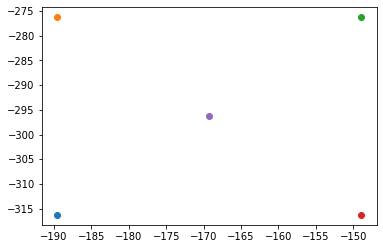

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(5):
    xp,yp = detectors_extent['R01_S00'][i][1]
    plt.scatter(xp,yp )
    print(xp,yp)

So the x pos , y pos in `focalplanelayout.txt` correspond to the center of each detector, recorded in the mapper as :

    import lsst.geom as geom
    import lsst.afw.cameraGeom as cameraGeom
    from lsst.obs.lsst import LsstCam
    camera = LsstCam().getCamera()
    for detector in camera:
        bbox = detector.getBBox()
        xc_px, yc_px = bbox.centerX, bbox.centerY
        xp_microns, yp_microns = detector.transform(geom.PointD(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)

The only thing is that currently the x,y are rotated.  So `xpos` is `yp_microns`,  and `ypos` is  `xp_microns`

# Update focalplanelayout.txt with new sensor names for guide and corner sensors 

### Development:

In [151]:
pathToFile = '/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_old.txt'
# read all the lines to a list : 
with open(pathToFile) as f:
    allLines = f.readlines()
    
headerLines=[]
contentLines=[]
# store the header part and content separately 
for line in allLines:
    if line.startswith('#'):
        headerLines.append(line)
    else:
        contentLines.append(line)


To change: sensor names, and shift for corner sensors (from 1000 to 1500 micrometers)....

In [34]:
headerLines

['# focal plane geometry layout data\n',
 '# \n',
 '# rows are the chips in the focal plane\n',
 '# columns are the name, x position (microns), y position (microns),\n',
 '# pixel size (microns), number of x pixels, number of y pixels,\n',
 '# device material (silicon or MCT) \n',
 '# type of device (note CMOS also means Fast Frame silicon CCD, and # readout integration mode (frame or sequence)\n',
 '# readout time (silicon CCD) or frame rate (CMOS)\n',
 '# group of sensors, 3 euler rotations (degrees), 3 translations (mm)\n',
 '# deformation type, deformation coefficients, QE variation (obsolete)\n',
 '#\n']

In [35]:
contentLines[:5]

['R00_S12    -254000.0 -211750.0 10.0  4000  4072 silicon CMOS  frame   0.1 100.0 Group2    -0.013636   0.000000   0.000000   0.020354  -0.030212   0.000000 zern      0.00  -2.08 -0.55  1.75 -0.08  0.17  0.50 -0.57 -0.20  0.51  0.34 -0.47  0.01 -0.18  0.20 -0.34  0.07 -0.30  0.17 -0.05  0.05 -0.44  0.00\n',
 'R00_S21    -211750.0 -254000.0 10.0  4000  4072 silicon CMOS  frame   0.1 100.0 Group2    -0.006303   0.000000   0.000000   0.047730  -0.013690   0.000000 zern      0.00   0.81 -0.59  1.33 -0.09  0.91  0.47 -0.00  0.01  0.23  0.05 -0.02 -0.10  0.35  0.74 -0.38 -0.07 -0.07  0.05 -0.00 -0.14 -0.11  0.00\n',
 'R00_S22_C0 -211750.0 -211750.0 10.0  2000  4072 silicon CCD frame    3.0 100.0 Group1    -0.002807   0.000000   0.000000  -9.974916  -0.024185   0.000000 zern  -1000.00  -2.41 -1.10 -1.17  0.21 -0.38  0.46  0.20 -0.00 -0.12 -0.19  0.17 -0.01  0.08  0.36 -0.09  0.03  0.04 -0.01  0.11 -0.17  0.32  0.00\n',
 'R00_S22_C1 -211750.0 -211750.0 10.0  2000  4072 silicon CCD frame    3.0

Test which content columns contain the defocal shift for corner sensors  (the header documentation is quite confusing ... )

In [36]:
# here content is one line per sensor, which 
# makes it easier...
for line in contentLines[:7]:
    #print(line)
    splitContent = line.split()
    sensorName  = splitContent[0]
#     xPosition = splitContent[1] # in microns 
#     yPosition = splitContent[2] # in microns
#     pixelSize = splitContent[3] # microns
#     numberXpx = splitContent[4]
#     numberYpx = splitContent[5]
#     deviceMaterial = splitContent[6] # silicon or MCT
#     deviceType = splitContent[7] # CMOS 
#     readoutIntegrationMode = splitContent[8] # frame or sequence
#     readoutTime = splitContent[9] # readout time (silicon CCD) or frame rate (CMOS)
#     frameRate = splitContent[10]
#     sensorGroup = splitContent[11] # sensor group
    
#     eulerRot1 = splitContent[12]
#     eulerRot2 = splitContent[13]
#     eulerRot3 = splitContent[14] # three Euler rotations in degrees
#     translation1 = splitContent[15]
#     translation2 = splitContent[16]
#     translation3 = splitContent[17] # three translations in mm 
    
#     deformationType  = splitContent[18]
    deformationCoeff = splitContent[19]
    #qeVariation = splitContent[20]
    
#     print(sensorName, xPosition, yPosition, pixelSize, numberXpx, numberYpx, deviceMaterial, deviceType, 
#           readoutIntegrationMode, readoutTime, frameRate, sensorGroup, eulerRot1, eulerRot2, eulerRot3,
#           translation1, translation2, translation3,deformationType, deformationCoeff)
    #, qeVariation)
    print(sensorName, deformationCoeff)

R00_S12 0.00
R00_S21 0.00
R00_S22_C0 -1000.00
R00_S22_C1 1000.00
R01_S00 0.00
R01_S01 0.00
R01_S02 0.00


Ok , so we need to change columnts [0] and [19]: 

In [47]:
newContentLines = []
for line in contentLines:
    splitContent = line.split()
    newSplitContent = splitContent.copy()
    
    # update the sensor name 
    sensorName  = splitContent[0]
    newName = getNewSensorName(sensorName)
    newSplitContent[0] = newName
    
    # update the defocal shift 
    deformationCoeff = splitContent[19]
    defCoeff = float(deformationCoeff)
    if abs(defCoeff)>10:
        sgn = np.sign(defCoeff)
        newDeformationCoeff = str(defCoeff + sgn*500.0)
        print(newDeformationCoeff)
        newSplitContent[19]  = newDeformationCoeff
    
    # append updated line adding line break character
    newContentLines.append(' '.join(newSplitContent)+'\n')

-1500.0
1500.0
-1500.0
1500.0
-1500.0
1500.0
-1500.0
1500.0


In [58]:
a = getNewSensorName('R00_S22')

In [59]:
a

'R00_S22'

In [41]:
contentLines[0]

'R00_S12    -254000.0 -211750.0 10.0  4000  4072 silicon CMOS  frame   0.1 100.0 Group2    -0.013636   0.000000   0.000000   0.020354  -0.030212   0.000000 zern      0.00  -2.08 -0.55  1.75 -0.08  0.17  0.50 -0.57 -0.20  0.51  0.34 -0.47  0.01 -0.18  0.20 -0.34  0.07 -0.30  0.17 -0.05  0.05 -0.44  0.00\n'

In [43]:
newContentLines[0]+'\n'

'R00_SG0 -254000.0 -211750.0 10.0 4000 4072 silicon CMOS frame 0.1 100.0 Group2 -0.013636 0.000000 0.000000 0.020354 -0.030212 0.000000 zern 0.00 -2.08 -0.55 1.75 -0.08 0.17 0.50 -0.57 -0.20 0.51 0.34 -0.47 0.01 -0.18 0.20 -0.34 0.07 -0.30 0.17 -0.05 0.05 -0.44 0.00\n'

In [271]:
# Store the header and updated content lines 
fname = "focalplanelayout_test.txt"
f = open(fname, "w")
f.writelines(headerLines)
f.writelines(newContentLines)
f.close()      
print('Saved as %s'%fname)

Saved as focalplanelayout_test.txt


# Production: all the code to update focalplanelayout.txt 

In [4]:
# Need to store each line of the other focalplanelayout to convey the zernike perturbations ...
headerLines, contentLinesZer = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_old.txt')


splitLinesZerDic = {}
for line in contentLinesZer:
    splitLinesZerDic[line.split()[0]] = line.split() # sensor name is the key 

In [5]:
import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()


# for detector in camera:
#     bbox = detector.getBBox()
#     xc_px, yc_px = bbox.centerX, bbox.centerY
#     xp_microns, yp_microns = detector.transform(geom.PointD(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    
    
# read the file and split into two lists
headerLines, contentLines = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_old.txt')

# update the content 
newContentLines = []
for line in contentLines:
    splitContent = line.split()
    newSplitContent = splitContent.copy()
    
    # update the sensor name 
    sensorName  = splitContent[0]
    newName = getNewSensorName(sensorName)
    newSplitContent[0] = newName
    
    # update the defocal shift 
    deformationCoeff = splitContent[19]
    defCoeff = float(deformationCoeff)
    if abs(defCoeff)>10:
        sgn = np.sign(defCoeff) # change +/- 1000 to +/- 1500 
        newDeformationCoeff = str(defCoeff + sgn*500.0)
        #print(newDeformationCoeff)
        newSplitContent[19]  = newDeformationCoeff
    
    # update the x,y position 
    detector = camera.get(newName)
    bbox = detector.getBBox()
    xc_px, yc_px = bbox.centerX, bbox.centerY
    xc_mm, yc_mm = detector.transform(geom.PointD(xc_px, yc_px), 
                                                cameraGeom.PIXELS, 
                                                cameraGeom.FOCAL_PLANE)
    
    xc_microns , yc_microns = 1000*xc_mm , 1000*yc_mm
    xpos, ypos = float(splitContent[1]), float(splitContent[2])
    #print(xpos, ypos, '-->', 
    #      yp_microns, xp_microns, 
    #      'dx:', xpos - yp_microns, 
    #      'dy:', ypos-xp_microns)
    newSplitContent[1] = str(round(yc_microns,2))
    newSplitContent[2] = str(round(xc_microns,2))
    
    
    # update the number of  x px, y px 
    xpx, ypx = splitContent[4], splitContent[5]
    
    xnew, ynew = bbox.getHeight(), bbox.getWidth() # rotated wrt lsstCam ... 
    newSplitContent[4] = str(xnew)
    newSplitContent[5] = str(ynew)
    
    # update the dx, dy - since we know the actual position, set these to 0 ...
    dx,dy,dz = float(splitContent[15]), float(splitContent[16]), float(splitContent[17])
    newSplitContent[15] = '0' # <-- set dx to 0 
    newSplitContent[16] = '0' # <-- set dy to 0 

    
    # change sensor.txt to zern, and append all parts that follow...
    # that way I can also use the 'new' format of focalplanelayout,
    # changing all after 'sensor.txt' to zern and the coefficients ... 
    newSplitContent[18]  = 'zern'
    newSplitContent[20:] = splitLinesZerDic[sensorName][20:]
    
    # append updated line 
    newContentLines.append(' '.join(newSplitContent)+'\n')
    
# store the updated version: the header and  updated  content lines 
fname = "/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_upd.txt"
f = open(fname, "w")
f.writelines(headerLines)
f.writelines(newContentLines)
f.close()      
print('Saved as %s'%fname)

Saved as /project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_upd.txt


#### Save a summary of updates to focalplanelayout:

Make a quick list of what would the positions  need to be for the center of each sensor for Dr Peterson:

sensorName  xPos  yPos   xPx   yPx    



In [35]:

import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()


# for detector in camera:
#     bbox = detector.getBBox()
#     xc_px, yc_px = bbox.centerX, bbox.centerY
#     xp_microns, yp_microns = detector.transform(geom.PointD(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    

# read the file and split into two lists
headerLines, contentLines = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_old.txt')

# update the content 
newSensorData = {'oldName':[],  'newName':[], 'xPx':[],'yPx':[], 
                 'xPos':[],'yPos':[], 'defocalOffset':[]
                }
for line in contentLines:
    splitContent = line.split()
    
    # update the sensor name 
    sensorName  = splitContent[0]
    newName = getNewSensorName(sensorName)
    newSensorData['oldName'].append(sensorName)
    newSensorData['newName'].append(newName)
    
    # update the defocal shift 
    deformationCoeff = splitContent[19]
    defCoeff = float(deformationCoeff)
    if abs(defCoeff)>10:
        sgn = np.sign(defCoeff) # change +/- 1000 to +/- 1500 
        defCoeff = defCoeff + sgn*500.0
        #print(newDeformationCoeff)
        #newSplitContent[19]  = newDeformationCoeff
    newSensorData['defocalOffset'].append(defCoeff)
    
    # update the x,y position 
    detector = camera.get(newName)
    bbox = detector.getBBox()
    xc_px, yc_px = bbox.centerX, bbox.centerY
    xc_mm, yc_mm = detector.transform(geom.PointD(xc_px, yc_px), 
                                                cameraGeom.PIXELS, 
                                                cameraGeom.FOCAL_PLANE)
    
    xc_microns , yc_microns = 1000*xc_mm , 1000*yc_mm
#     xpos, ypos = float(splitContent[1]), float(splitContent[2])
    #print(xpos, ypos, '-->', 
    #      yp_microns, xp_microns, 
    #      'dx:', xpos - yp_microns, 
    #      'dy:', ypos-xp_microns)
#     newSplitContent[1] = str(round(yc_microns,2))
#     newSplitContent[2] = str(round(xc_microns,2))
    newSensorData['xPos'].append(round(yc_microns,2))
    newSensorData['yPos'].append(round(xc_microns,2))
        
    # update the number of  x px, y px 
#     xpx, ypx = splitContent[4], splitContent[5]
    
    xPxNew, yPxNew = bbox.getHeight(), bbox.getWidth() # rotated wrt lsstCam ... 
    newSensorData['xPx'].append(xPxNew)
    newSensorData['yPx'].append(yPxNew)
    
#     newSplitContent[4] = str(xnew)
#     newSplitContent[5] = str(ynew)
    
    # update the dx, dy - since we know the actual position, set these to 0 ...
#     dx,dy,dz = float(splitContent[15]), float(splitContent[16]), float(splitContent[17])
#     newSplitContent[15] = '0' # <-- set dx to 0 
#     newSplitContent[16] = '0' # <-- set dy to 0 

    
    # change sensor.txt to zern, and append all parts that follow...
#     newSplitContent[18]  = 'zern'
#     newSplitContent[20:] = splitLinesZerDic[sensorName][20:]
    
#     # append updated line 
#     newContentLines.append(' '.join(newSplitContent)+'\n')

newSensorTable = Table(data=[newSensorData[key] for key in newSensorData.keys()],
                       names=list(newSensorData.keys())
                      )
newSensorTable.write('/project/scichris/aos/focalplanelayout_update_summary.txt', format='ascii')


## Update focalplanelayout for comcam : 

In [27]:
headerLines, contentLines = readFile('/project/scichris/aos/phosim_syseng4/data/comcam/focalplanelayout.txt')
#sensorData = storeSensorDataAsDictionary(contentLines)

In [28]:
headerLines2, contentLines2 = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_old.txt')
#sensorData = storeSensorDataAsDictionary(contentLines2)

In [29]:
contentLines[0]

'R00_S12    -254000.0 -211750.0 10.0  4000  4072 silicon CMOS  frame   0.1 100.0 Group2    -0.013636   0.000000   0.000000   0.020354  -0.030212   0.000000 zern      0.00  -2.08 -0.55  1.75 -0.08  0.17  0.50 -0.57 -0.20  0.51  0.34 -0.47  0.01 -0.18  0.20 -0.34  0.07 -0.30  0.17 -0.05  0.05 -0.44  0.00\n'

In [31]:
for sensorName in camera.getNameIter():
    print(sensorName)

R22_S22
R22_S12
R22_S21
R22_S01
R22_S00
R22_S02
R22_S10
R22_S20
R22_S11


In [41]:
'R22_S00' in list(camera.getNameMap().keys())

True

## Do the PR to phosim_syseng4:  

https://jira.lsstcorp.org/browse/DM-28557
    
    cd /project/scichris/aos/phosim_syseng4/
    git checkout -b tickets/DM-28557
    
    cd /data/lsst/
    
    diff -s focalplanelayout.txt focalplanelayout_DM-28553.txt 
    diff -s segmentation.txt segmentation_DM-28553.txt 
    # to show that the files are the same 
    
Useful : https://guides.github.com/features/mastering-markdown/ 
    

After the PR got merged in github ,  I do https://git-scm.com/book/en/v2/Git-Basics-Tagging 

    git checkout aos 
    git pull
    git tag -a v1.0.5 -m "Merge pull request #6 from lsst-ts/tickets/DM-28557" 
    git push origin --tags 

### Get the segmentation.txt and focalplanelayout.txt from the phosim master branch :

    # on LSP or NCSA, this juist gets the most recent focalplanelayout and segmentation files from bitbucket 
    cd /project/scichris/aos/phosim_syseng4/data/lsst/
    curl -OL https://bitbucket.org/phosim/phosim_release/raw/178d41cb0fa5ec44797029de3f65fb50c03eff8c/data/lsst/focalplanelayout.txt


    curl -OL https://bitbucket.org/phosim/phosim_release/raw/178d41cb0fa5ec44797029de3f65fb50c03eff8c/data/lsst/segmentation.txt


Run phosim with these bitbucket versions on the corner sensors to see if there is any result : 

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03
    source "/software/lsstsw/stack/loadLSST.bash"   # to have python 
    source "/project/scichris/aos/setup_aos_current.sh"  # to setup the stack with python, I don't really need any other aos components  

    cd /project/scichris/aos/segmentation_update/corner_sensors/bitbucket_ver54/
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starWfs.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/bitbucket_ver54/  > starPhoSim.log 2>&1

In [258]:
#newContentLines

Test that :  run the `phosim_syseng4` phosim with `ts_phosim`   `imgCloseLoop` for famcam, ensure it converges:

Replace the `segmentation.txt` and `focalplanelayout.txt` files 
at   `phosim_syseng4`  directory : 
    
    cd /project/scichris/aos/phosim_syseng4/data/lsst/
    mv focalplanelayout.txt old_focalplanelayout.txt
    mv segmentation.txt old_segmentation.txt 

    cp /home/scichris/notebooks/focalplanelayout_test.txt focalplanelayout.txt
    cp /home/scichris/notebooks/segmentation_test.txt segmentation.txt

Run that on NCSA lsst-devl03, because that's where I setup the AOS packages... 

    # do it on NCSA lsst-devl03,  because AOS environment was 
    # built there ...


    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03

    # setup the stack and AOS 
    source "/software/lsstsw/stack/loadLSST.bash"
    source "/project/scichris/aos/setup_aos_current.sh"

    # use my changed versions of 
    # obs_lsst and phosim_utils 
    # from ticket branches 
    cd /project/scichris/dev/obs_lsst_dev/
    setup -k -r . 

    cd /project/scichris/dev/phosim_utils/
    setup -k -r .

    # show that the correct location is being used...
    eups list obs_lsst
    eups list phosim_utils

    cd /project/scichris/aos/ts_phosim/
    
for comcam (i.e. R22 of lsstCam) 

    python bin.src/imgCloseLoop.py --inst comcam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyComCam.txt --output /project/scichris/aos/results_comcam/

for famcam (i.e. lsstCam ) 
    
    python bin.src/imgCloseLoop.py --inst lsstfam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyLsstFam.txt --output /project/scichris/aos/results_lsstfam_test/

## Run just phosim on lsst-devl03 with corner sensors before and after the change 

1) Before the change : 
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    # Zx... no shift,

    ssh lsst-devl03
    lscpu# to show number of available cores  : this one has 32v

    source "/software/lsstsw/stack/loadLSST.bash"
    source "/project/scichris/aos/setup_aos_current.sh"

    cd /project/scichris/aos/segmentation_update/corner_sensors/before/
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starWfs.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/before/  > starPhoSim.log 2>&1

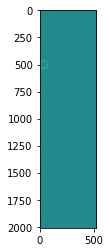

In [63]:
%matplotlib inline
import astropy.io.fits as fits
import matplotlib.pyplot as plt
fname = '/project/scichris/aos/segmentation_update/corner_sensors/before/\
lsst_a_9006002_f1_R00_S22_C03_E000.fits.gz'
hdul = fits.open(fname)[0]
plt.imshow(hdul.data, )
    

2) After the change :

    cd /project/scichris/aos/phosim_syseng4/data/lsst/
    cp segmentation.txt segmentation_old.txt
    cp focalplanelayout.txt focalplanelayout_old.txt
    
    cp segmentation_upd.txt segmentation.txt 
    cp focalplanelayout_upd.txt focalplanelayout.txt 

    cd /project/scichris/aos/segmentation_update/corner_sensors/after/
        python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starWfs.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/ > starPhoSim.log 2>&1
    
    

and it doesn't make anything ! Need to find out what am I missing, since I updated `segmentation.txt` and `focalplanelayout.txt` 

I checked David Thomas' commit to `phosim_syseng4`, but I can't figure out whether changing the `segmentation.txt` and `focalplanelayout.txt` is sufficient ... https://github.com/lsst-ts/phosim_syseng4/tree/aos/data 

In [68]:
import astropy.io.fits as fits

# R00_S22 --> R00_SW1 ,  
# C03 --> C14 
fname = '/project/scichris/aos/segmentation_update/corner_sensors/after/\
lsst_a_9006002_f1_R00_SW1_C14_E000.fits.gz'
hdul = fits.open(fname)[0]

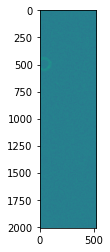

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(hdul.data, )#vmin=970,vmax=1000)

ok, it works! Now, add changing the size & x,y location of each CCD ... 

3) Updated geometry of segmentation.txt and focalplanelayout.txt  ... see if that works!   It probably does for the corner sensors since I didn't change anything there..So need to simulate one star per CCD of the main rafts , and see if they are in the center of each CCD still ... 



    cd /project/scichris/aos/segmentation_update/corner_sensors/afterGeom/
        python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starWfs.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/ > starPhoSim.log 2>&1

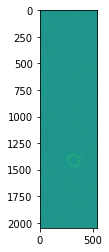

In [225]:
import astropy.io.fits as fits

# R00_S22 --> R00_SW1 ,  
# C03 --> C14 
fname = '/project/scichris/aos/segmentation_update/corner_sensors/afterGeom/\
lsst_a_9006002_f1_R00_SW1_C11_E000.fits.gz'
hdul = fits.open(fname)[0]

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(hdul.data, )#vmin=970,vmax=1000)

repackage and ingest ... 

    source "/project/scichris/aos/setup_aos_current.sh"
    # do the same for  phosim_utils - 
    # use the ticket version of the repackager .. 
    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836
    setup -k -r .

    phosim_repackager.py /project/scichris/aos/segmentation_update/corner_sensors/afterGeom/ --out_dir=/project/scichris/aos/segmentation_update/corner_sensors/afterGeom/repackaged/


    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/input_afterGeom/ /project/scichris/aos/segmentation_update/corner_sensors/afterGeom/repackaged/*.fits



Where is the star? I must have done something wrong - compare the content of segmentation and focalplanelayout before/ after ... 

In [229]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/input_afterGeom/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(run='9006002', visit=4021123106002, raftName='R00', detectorName='SW1')
butler.datasetExists('raw', dataId)


True

In [230]:
exposure = butler.get('raw', **dataId) 
image = exposure.image.array


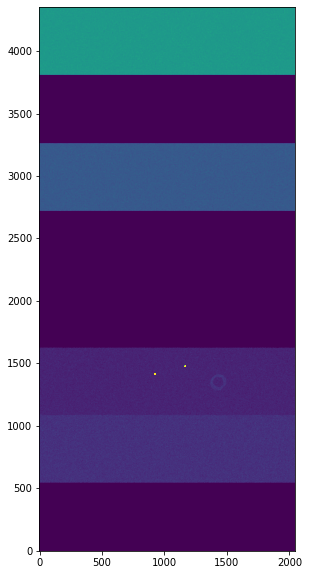

In [258]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmin=1000,vmax=1050)


(array([  11403.,  703326., 1696565., 1698782.,  482938., 1796870.,
        1339198.,  872366.,  309468.,    1978.]),
 array([ 950.,  960.,  970.,  980.,  990., 1000., 1010., 1020., 1030.,
        1040., 1050.], dtype=float32),
 <BarContainer object of 10 artists>)

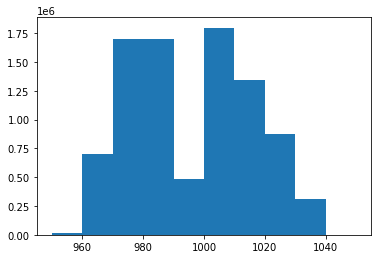

In [255]:
plt.hist(np.ravel(image), range=(950,1050))

4) Updated values of position, etc. , using new focalplanelayout format,  but changing "sensor.txt" to "zern", and appending the old deformation values 

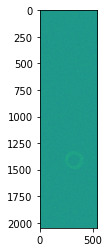

In [33]:
import astropy.io.fits as fits

# R00_S22 --> R00_SW1 ,  
# C03 --> C14 
fname = '/project/scichris/aos/segmentation_update/corner_sensors/bitbucket_ver54/\
lsst_a_9006002_f1_R00_SW1_C11_E000.fits.gz'
hdul = fits.open(fname)[0]

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(hdul.data, )#vmin=970,vmax=1000)


5) Run the arrows/letters , repackage  and ingest,  see what happens....


Get the arrows/letters from epyc via scp : 

    cd /project/scichris/aos/segmentation_update/corner_sensors/

    scp suberlak@epyc.astro.washington.edu:/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStarsLetters_2020_44/iter0/pert/starIntra.inst  starArrowsLetters.inst
    
    
    --> changed  SIM_VISTIME to 1.0  seconds 
    --> removed "move" commands (since there isn't any for the corner sensors) 
    --> added "sunalt -90" to keep the twilight issues at bay ... 
    
    
    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/
        python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starArrowsLetters.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/ > starPhoSim.log 2>&1
        
        
    # do the same for  phosim_utils - 
    # use the ticket version of the repackager .. 
    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836
    setup -k -r .

    phosim_repackager.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/ --out_dir=/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/

    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/
    mkdir input
    cd input
    echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > _mapper
    ingestImages.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input/ /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/*.fits

    

In [62]:
# show with butler what it looks like ... 

import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot='/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/input/'
butler = dafPersist.Butler(dataRoot, )
dataId = dict(run='9006002', visit=4000021706002, raftName='R00', detectorName='SW1')
butler.datasetExists('raw', dataId)


True

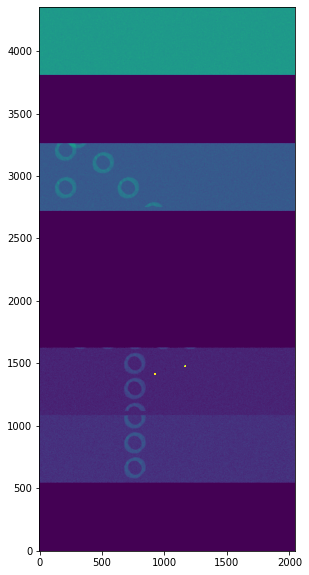

In [63]:
exposure = butler.get('raw', **dataId) 
image = exposure.image.array

fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmin=1000,vmax=1050)


this is because the repackager is now (unneccessarily) moving the channels around and transposing ... Need to change that in the repackager. 

6) Make the v5.4 installed at NCSA on `lsst-devl03` ( trying to use the latest version with the AOS pipeline...) 
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"
    cd /project/scichris/aos/
    
    curl -OL https://bitbucket.org/phosim/phosim_release/get/v5.4.1.tar.gz
    tar -xvf v5.4.1.tar.gz

    cd phosim-phosim_release-d70c7038139c
    ./configure
    make


I run into sevaral issues, even selecting manually 

    Please enter the path to libcfitsio.a: ${CONDA_PREFIX}/lib
    Please enter the path to fitsio.h: ${CONDA_PREFIX}/include

    Please enter the path to libfftw3.a: ${CONDA_PREFIX}/lib
    Please enter the path to fftw3.h: ${CONDA_PREFIX}/include

and adding in `source/trim/makefile` to the CFLAGS  `-I ${CONDA_PREFIX}/include` and to LFLAGS `-L ${CONDA_PREFIX}/lib` , it compiles, but it does not work when I try to run the  test example `python phosim.py examples/star -c examples/nobackground `



7) Use the **updated focalplanelayout and segmentation**, using the (0,0) as the X,Y translations, and keeping the deformation coefficients unchanged. Change the repackager to reflect the change of the sensor names for the corner sensors.

This is done easiest with 

    sshfs scichris@lsst-login02.ncsa.illinois.edu:/project/scichris/dev/ ~/lsstdevl/
   
   
Then run the repackager (eg. on the jupyterhub terminal tab) with 

    cd /project/scichris/dev/phosim_utils/
    git checkout tickets/DM-26836
    setup -k -r .

    phosim_repackager.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/ --out_dir=/project/scichris/aos/segmentation_update/corner_sensors/arrowsLetters/repackaged/


Test with  a) corner sensor arrows (works)  b) comcam arrows letters  c) full array eg. star on each sensor with Bryce's code:



Get comcam arrows. I think I need to grab the `inst` and `cmd` files from `epyc` : 

    --> on LSP  or NCSA < ----
 
    cd /project/scichris/aos/segmentation_update/comcam/
    scp suberlak@epyc.astro.washington.edu:/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_arrow/singleArrowDec/iter0/pert/starExtra.inst .
    
    nano starExtra.inst 
     --> changed  SIM_VISTIME to 1.0  seconds 
    
    ( the star.cmd  contains the same as /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd ) 
    
    cp /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd . 
 
   

    
    --> on NCSA  - only there  phosim works ... 
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"

    cd /project/scichris/aos/segmentation_update/comcam/
        python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/comcam/starExtra.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/comcam/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/comcam/arrows/ > starPhoSim.log 2>&1
        
        
        
        

8) if `detector.getPhysicalType` is  `E2V` I changed serialread  in `segmentation.txt` so that its `-1 -1 ` for chips 00:07  and `1 1` (unchanged) for chips 10:17. This is because there is a different direction of serial read for E2V. And phosim has everything rotated by 90 degrees which adds confusion.   For ITL its unchanged (`1 -1` for 00:07 and `1 1` for 10:17). 


Just run phosim: 

     --> on NCSA  - only there  phosim works ... 
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"    # need that for python 
    setup lsst_distrib 

    cd /project/scichris/aos/segmentation_update/comcam/
    mkdir arrowsUpdSerial
     python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/comcam/starExtra.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/comcam/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial/ > starPhoSim.log 2>&1




9) Apart from serial update, I also change xlo xhi ylo yhi (it was only updating the other half of the E2V chips ... )

 --> on NCSA  - only there  phosim works ... 
 
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"    # need that for python 
    setup lsst_distrib 


    cd /project/scichris/aos/segmentation_update/comcam/
    mkdir arrowsUpdSerial2
    
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/comcam/starExtra.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/comcam/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/ > starPhoSim.log 2>&1

In [ ]:
show which 

10) Updated  read direction : from  1 -1 for SW1 chips to  1 1  , so that no up-down flips needed ...  Run phosim to see if the change works : 
    
    
     --> on NCSA  - only there  phosim works ... 
 
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"    # need that for python 
    setup lsst_distrib 

    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/
        
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/corner_sensors/starArrowsLetters.inst -i lsst -e 1 -c /project/scichris/aos/segmentation_update/corner_sensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/ > starPhoSim.log 2>&1
        
        
      

11) Test with a main raft ITL sensor. To do that, use Bryce's code to make stars at specific locations : 
`/astro/store/epyc/users/brycek/Commissioning/aos/clean_setup/ts_wep/policy/cwfs/templateData/starExtra.inst`
made with `/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks/create_template_instance_catalog.ipynb`

I open these on https://epyc.astro.washington.edu/jupyter/user/suberlak/lab  (some issues with branches)...

Instead, I used my own code using (lsst_phosim) kernel with old phosimMapper positions `AOS_sensor_outlines_arrows.ipynb` 

I get the inst file with arrows  / outlines according to phosimMapper focalplanelayout (not far off if I'm just trying to test ISR) : 

    ( on LSP ) : 

    scp suberlak@epyc.astro.washington.edu:/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/star.inst .
    
    nano star.inst 
     --> changed  SIM_VISTIME to 1.0  seconds 
     --> changed :  move 10 1500.0000  
     --> changed mjd to 57648  , since that was the one used for 
          skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos, mjd)
          
    ( on NCSA ) : 
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"    # need that for python 
    setup lsst_distrib 

    cd /project/scichris/aos/segmentation_update/famcam/
           

In [5]:
def _getCustomRaftsSensorNameList(rafts=['14']):

    chips  = ['00','01','02',
          '10','11','12',
          '20','21','22']
    sensors = []
    for r in rafts:
        for c in chips:
            s = "R%s_S%s"%(r,c)
            sensors.append(s)
    sensorNameList = sensors
    return sensorNameList

def _sensorNameListToString(sensorNameList):
    sensors  = ''
    for sensor in sensorNameList:
        sensors += "%s|"%sensor
    return sensors


In [ ]:
sensorNameList = _getCustomRaftsSensorNameList(['01'])
sensorNameString= _sensorNameListToString(sensorNameList)

12) Run  `-i comcam`  with updated segmentation.txt and focalplanelayout.txt ... See if that works! 

   --> on NCSA  - only there  phosim works ... 
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack3/loadLSST.bash"

    cd /project/scichris/aos/segmentation_update/comcam/
        python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/segmentation_update/comcam/starExtra.inst -i comcam -e 1 -c /project/scichris/aos/segmentation_update/comcam/noBkgnd.cmd -p 25 -o /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/ > starPhoSim.log 2>&1
        
        

Repackage the data with an updated repackager (that can handle  `LsstComCam` when selecting `--prefix comcam` : 

    cd /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/
    phosim_repackager.py /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/ --out_dir /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/ --prefix comcam --verbose



Try using obs_lsst header translator to see if it passes through : 

    translate_header.py -p lsst.obs.lsst.translators /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits 

### Show the positions of each raft in focalplanelayout before & after the change ... 

In [ ]:
# read the file and split into two lists
headerLines, contentLinesOld = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_v54.txt')

# read the file and split into two lists
headerLines, contentLinesNew = readFile('/project/scichris/aos/phosim_syseng4/data/lsst/focalplanelayout_upd.txt')


fpl_old = dict()
for line in contentLinesOld:
    splitline = line.split()
    sensor = splitline[0]
    xpos, ypos = float(splitline[1]), float(splitline[2])
    dx,dy,dz = float(splitline[15]), float(splitline[16]), float(splitline[17])
    
    fpl_old[sensor] = [xpos+dx, ypos+dy]
    
fpl_new = dict()
for line in contentLinesNew:
    splitline = line.split()
    sensor = splitline[0]
    xpos, ypos = float(splitline[1]), float(splitline[2])
    dx,dy,dz = float(splitline[15]), float(splitline[16]), float(splitline[17])
    
    fpl_new[sensor] = [xpos+dx, ypos+dx]
    
    
pairs_old   = []
for key in fpl_old.keys():
    pairs_old.append((fpl_old[key][0], fpl_old[key][1]))
    
pairs_old_list = list(map(list, pairs_old))


pairs_new   = []
for key in fpl_new.keys():
    pairs_new.append((fpl_new[key][0], fpl_new[key][1]))

pairs_new_list = list(map(list, pairs_new))

add information about the four corners ... 

In [41]:
camera = LsstCam().getCamera()
detectors_extent = dict()

four_corners_T = {}
for detector in camera:
    detectors_extent[detector.getName()] = []
    four_corners_T[detector.getName()] = []
    bbox = detector.getBBox()
    x0, y0 = bbox.getBegin()
    x1, y1 = bbox.getEnd() - geom.ExtentI(1, 1)
    
    xc, yc = bbox.centerX, bbox.centerY
    
    for x, y in [(x0, y0), (x0, y1), (x1, y1), (x1, y0), (xc,yc)]:
        xp, yp = detector.transform(geom.PointD(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
        #print(f"{detector.getName():10}  ({x:4}, {y:4}) -> ({xp:.4f}, {yp:.4f}) mm")
        
        detectors_extent[detector.getName()].append([(x,y),(1000*xp,1000*yp)])
        four_corners_T[detector.getName()].append((1000*yp, 1000*xp))

In [57]:
fpl_diff = {}
camera = LsstCam().getCamera()
for sensor in fpl_old.keys():
    newSensor = getNewSensorName(sensor)
    dx = fpl_old[sensor][0]-fpl_new[newSensor][0]
    dy = fpl_old[sensor][1]-fpl_new[newSensor][1]
    fpl_diff[newSensor] = [dx,dy]
    detector = camera.get(newSensor)
    #print(detector.getPhysicalType(), sensor,'-->', newSensor, dx,dy)

In [58]:
fpl_old.keys()

dict_keys(['R00_S12', 'R00_S21', 'R00_S22_C0', 'R00_S22_C1', 'R01_S00', 'R01_S01', 'R01_S02', 'R01_S10', 'R01_S11', 'R01_S12', 'R01_S20', 'R01_S21', 'R01_S22', 'R02_S00', 'R02_S01', 'R02_S02', 'R02_S10', 'R02_S11', 'R02_S12', 'R02_S20', 'R02_S21', 'R02_S22', 'R03_S00', 'R03_S01', 'R03_S02', 'R03_S10', 'R03_S11', 'R03_S12', 'R03_S20', 'R03_S21', 'R03_S22', 'R04_S10', 'R04_S20_C0', 'R04_S20_C1', 'R04_S21', 'R10_S00', 'R10_S01', 'R10_S02', 'R10_S10', 'R10_S11', 'R10_S12', 'R10_S20', 'R10_S21', 'R10_S22', 'R11_S00', 'R11_S01', 'R11_S02', 'R11_S10', 'R11_S11', 'R11_S12', 'R11_S20', 'R11_S21', 'R11_S22', 'R12_S00', 'R12_S01', 'R12_S02', 'R12_S10', 'R12_S11', 'R12_S12', 'R12_S20', 'R12_S21', 'R12_S22', 'R13_S00', 'R13_S01', 'R13_S02', 'R13_S10', 'R13_S11', 'R13_S12', 'R13_S20', 'R13_S21', 'R13_S22', 'R14_S00', 'R14_S01', 'R14_S02', 'R14_S10', 'R14_S11', 'R14_S12', 'R14_S20', 'R14_S21', 'R14_S22', 'R20_S00', 'R20_S01', 'R20_S02', 'R20_S10', 'R20_S11', 'R20_S12', 'R20_S20', 'R20_S21', 'R20_S22'

In [119]:
detectors_extent['R01_S00'][i][1]

(-169260.00000000003, -296260.0)

In [92]:
# new names
guide_sensors=['R00_SG0','R00_SG1','R04_SG0','R04_SG1','R40_SG0','R40_SG1','R44_SG0','R44_SG1']
corner_sensors=['R00_SW0','R00_SW1','R04_SW0','R04_SW1','R40_SW0','R40_SW1','R44_SW0','R44_SW1']


In [111]:
fpl_old['R00_S12']

[-254000.0, -211750.0]

In [182]:
fpl_new['R00_SW0']

[-202615.0, -214240.0]

In [112]:
four_corners['R00_SG0']

[(-192235.0, -279105.0),
 (-232225.00000000003, -279105.0),
 (-232225.0, -238395.0),
 (-192235.0, -238395.0),
 (-212230.00000000003, -258750.0)]

In [151]:
pairs_new[:4]


pairs_

[(-258750.0, -212230.0),
 (-212230.0, -258730.0),
 (-225885.0, -214260.0),
 (-202615.0, -214240.0)]

In [153]:
pairs_old[:4]-pairs_new[:4]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

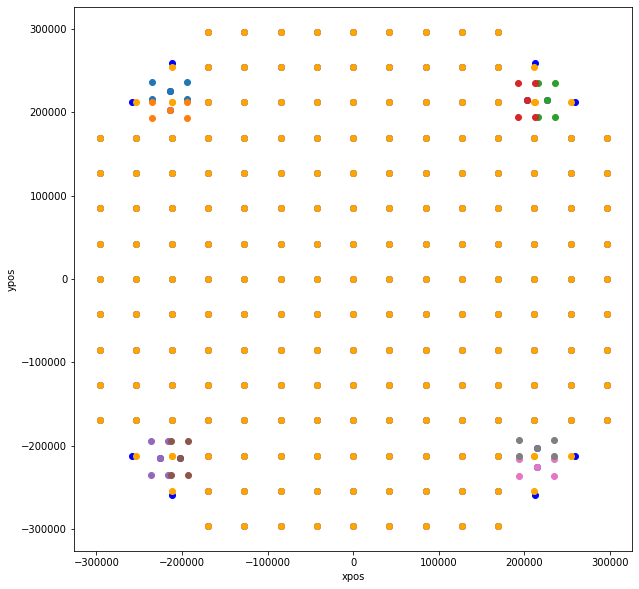

In [51]:
import matplotlib.pyplot as plt
#https://stackoverflow.com/questions/17478779/make-scatter-plot-from-set-of-points-in-tuples
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(*zip(*pairs_old), c='blue')
plt.scatter(*zip(*pairs_new), c='orange')
plt.xlabel('xpos')
plt.ylabel('ypos')
corner_sensors_old = ['R04_S20_C0','R04_S20_C1','R44_S00_C0','R44_S00_C1',
                 'R00_S22_C0','R00_S22_C1', 'R40_S02_C0','R40_S02_C1']


for sensor in corner_sensors_old:
    newSensor = getNewSensorName(sensor)
    plt.scatter(*zip(*four_corners_T[newSensor]))

In [39]:
corner_sensors_old = ['R04_S20_C0','R04_S20_C1','R44_S00_C0','R44_S00_C1',
                 'R00_S22_C0','R00_S22_C1', 'R40_S02_C0','R40_S02_C1']

for sensor in corner_sensors_old:
    newSensor = getNewSensorName(sensor)
    print(sensor, fpl_old[sensor], fpl_new[newSensor], fpl_diff[newSensor])

KeyError: 'R04_SW1'

In [141]:
R00_S22_C0: -9.974916  -0.024185
R00_S22_C1: 10.070605  -0.016132

[(192235.0, 238375.0),
 (232225.00000000003, 238375.0),
 (232225.00000000003, 279085.0),
 (192235.0, 279085.0),
 (212230.00000000003, 258730.00000000003)]

In [128]:
#four_corners[guide]

So it appears that the famcam was all shifted to the left almost uniformly... That shouldn't be the case, since we only wanted to change the position of ITL/ E2V that did not correspond ... 

In [1]:
import numpy

In [2]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot='/project/scichris/aos/segmentation_update/comcam/imgCloseLoop3/input/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4021123106001, raftName='R22', detectorName='S11')
exposure = postISRbutler.get('postISRCCD', **dataId) 
image = exposure.image.array



/project/scichris/dev/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():
/project/scichris/dev/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():


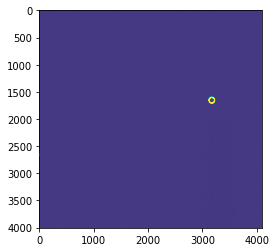

In [6]:
plt.imshow(image, vmax=200)

## Show the postISR image ...

In [7]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot='/project/scichris/aos/results_lsstfam_noCrosstalk2/input3/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4021123106001, raftName='R32', detectorName='S11')
exposure = postISRbutler.get('postISRCCD', **dataId) 
image = exposure.image.array


In [10]:
det = exposure.getDetector()
amp = det[0]
print(amp.getName(), amp.getRawHorizontalOverscanBBox())

C10 (minimum=(0, 2094), maximum=(53, 4095))


In [ ]:
plt.style.use('dark_background')

In [29]:
%matplotlib ipympl
#plt.rcParams['figure.figsize'] = [7, 6]
import lsst.afw.display as afwDisplay
import lsst.afw.cameraGeom.utils as cgUtils
afwDisplay.setDefaultBackend("matplotlib")
disp = afwDisplay.Display(2, reopenPlot=True)
disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
disp.setImageColormap('gray')
disp.scale('linear', *(['zscale'] if True else [12340, 12470]))


disp.mtv(exposure, title=f"{dataId}")
cgUtils.overlayCcdBoxes(exposure.getDetector(), isTrimmed=False, display=disp)
disp.zoom(16, 2300, 2048)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
cgUtils.makeImageFromCcd??

Signature:
cgUtils.makeImageFromCcd(
    ccd,
    isTrimmed=True,
    showAmpGain=True,
    imageFactory=<class 'lsst.afw.image.image.image.ImageU'>,
    rcMarkSize=10,
    binSize=1,
)
Source:   
def makeImageFromCcd(ccd, isTrimmed=True, showAmpGain=True, imageFactory=afwImage.ImageU, rcMarkSize=10,
                     binSize=1):
    """Make an Image of a CCD.

    Parameters
    ----------
    ccd : `lsst.afw.cameraGeom.Detector`
        Detector to use in making the image.
    isTrimmed : `bool`
        Assemble a trimmed Detector image.
    showAmpGain : `bool`
        Use the per-amp gain to color the pixels in the image?
    imageFactory : callable like `lsst.afw.image.Image`
        Image type to generate.
    rcMarkSize : `float`
        Size of the mark to make in the amp images at the read corner.
    binSize : `int`
        Bin the image by this factor in both dimensions.

    Returns
    -------
    image : `lsst.afw.image.Image`
        Image of the Detector (type return

In [55]:
cgUtils.assembleAmplifierImage?

Signature: cgUtils.assembleAmplifierImage(destImage, rawImage, amplifier)
Docstring:
Assemble the amplifier region of an image from a raw image.

Parameters
----------
destImage : `lsst.afw.image.Image` or `lsst.afw.image.MaskedImage`
    Assembled image; the region amplifier.getBBox() is overwritten with
    the assembled amplifier image.
rawImage : `lsst.afw.image.Image` or `lsst.afw.image.MaskedImage`
    Raw image (same type as destImage).
amplifier : `lsst.afw.cameraGeom.Amplifier`
    Amplifier geometry, with raw amplifier info.

Raises
------
RuntimeError
    Raised if image types do not match or amplifier has no raw amplifier info.
File:      /opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/afw/21.0.0-7-g484459ba0+d6ece73efd/python/lsst/afw/cameraGeom/assembleImage.py
Type:      function


In [53]:
image = cgUtils.makeImageFromCcd??


Signature:
cgUtils.makeImageFromCcd(
    ccd,
    isTrimmed=True,
    showAmpGain=True,
    imageFactory=<class 'lsst.afw.image.image.image.ImageU'>,
    rcMarkSize=10,
    binSize=1,
)
Source:   
def makeImageFromCcd(ccd, isTrimmed=True, showAmpGain=True, imageFactory=afwImage.ImageU, rcMarkSize=10,
                     binSize=1):
    """Make an Image of a CCD.

    Parameters
    ----------
    ccd : `lsst.afw.cameraGeom.Detector`
        Detector to use in making the image.
    isTrimmed : `bool`
        Assemble a trimmed Detector image.
    showAmpGain : `bool`
        Use the per-amp gain to color the pixels in the image?
    imageFactory : callable like `lsst.afw.image.Image`
        Image type to generate.
    rcMarkSize : `float`
        Size of the mark to make in the amp images at the read corner.
    binSize : `int`
        Bin the image by this factor in both dimensions.

    Returns
    -------
    image : `lsst.afw.image.Image`
        Image of the Detector (type return

In [ ]:
image = cgUtils.makeImageFromCcd

In [ ]:
image = cgUtils.makeImageFromCcd

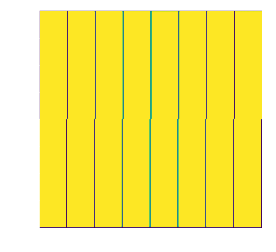

In [51]:
%matplotlib inline
plt.imshow(image, vmax=1500)

    Notes
    -----
    The colours are:
    - Entire detector        GREEN
    - All data for amp       GREEN
    - HorizontalPrescan      YELLOW
    - HorizontalOverscan     RED
    - Data                   BLUE
    - VerticalOverscan       MAGENTA
    - VerticalOverscan       MAGENTA